# MNISTでセマンティックセグメンテーションに挑戦



In [1]:
import os
import shutil
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import binarybrain as bb

In [2]:
print(bb.get_version_string())
#print(bb.get_device_name(0))

4.1.5


## 初期設定

In [3]:
# configuration
bb.set_device(0)

net_name               = 'MnistSemanticSegmentation'
data_path              = os.path.join('./data/', net_name)

rtl_sim_path           = '../../verilog/mnist'
rtl_module_name        = 'MnistSemanticSegmentation'
output_velilog_file    = os.path.join(data_path, net_name + '.v')
sim_velilog_file       = os.path.join(rtl_sim_path, rtl_module_name + '.v')

bin_mode               = True
frame_modulation_size  = 3
depth_integration_size = 1
epochs                 = 0
mini_batch_size        = 16

## データセット準備

データセットを自作する
数値が中央に来るピクセル以外も学習させる必要がるため、28x28のMNSIT画像をタイル状に並べて学習データを作る
数字の無い位置も併せて11クラス分類できるようにデータを作成。

In [4]:
# 並べるタイル数
rows=3
cols=3

# 面積の比率で重み作成(利用しない)
if False:
    areas = np.zeros((11))
    for img, label in dataset_train:
        img = img.numpy()
        areas[label] += np.mean(img)
        areas[10] += np.mean(1.0-img)
    areas /= len(dataset_train)

    wight = 1 / areas
    wight /= np.max(wight)

def make_teacher_image(gen, rows, cols, margin=0):
    source_img  = np.zeros((1, rows*28, cols*28), dtype=np.float32)
    teaching_img = np.zeros((11, rows*28, cols*28), dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            x = col*28
            y = row*28
            img, label = gen.__next__()
            source_img[0,y:y+28,x:x+28] = img
            teaching_img[label,y:y+28,x:x+28] = img
            teaching_img[10,y:y+28,x:x+28] = (1.0-img)
    teaching_img = (teaching_img > 0.5).astype(np.float32)
    
    # ランダムに反転
    if random.random() > 0.5:
        source_img = 1.0 - source_img
    
    return source_img, teaching_img[:,margin:-margin,margin:-margin]

def transform_data(dataset, n, rows, cols, margin):
    def data_gen():
        l = len(dataset)
        i = 0
        while True:
            yield dataset[i%l]
            i += 1
    
    gen = data_gen()
    source_imgs = []
    teaching_imgs = []
    for _ in range(n):
        x, t = make_teacher_image(gen, rows, cols, margin)
        source_imgs.append(x)
        teaching_imgs.append(t)
    return source_imgs, teaching_imgs

class MyDatasets(torch.utils.data.Dataset):
    def __init__(self, source_imgs, teaching_imgs, transforms=None):
        self.transforms = transforms
        self.source_imgs = source_imgs
        self.teaching_imgs = teaching_imgs
        
    def __len__(self):
        return len(self.source_imgs)

    def __getitem__(self, index):
        source_img = self.source_imgs[index]
        teaching_img = self.teaching_imgs[index]
        if self.transforms:
            source_img, teaching_img = self.transforms(source_img, teaching_img)
        return source_img, teaching_img

# dataset
dataset_path = './data/'
dataset_train = torchvision.datasets.MNIST(root=dataset_path, train=True, transform=transforms.ToTensor(), download=True)
dataset_test  = torchvision.datasets.MNIST(root=dataset_path, train=False, transform=transforms.ToTensor(), download=True)

    
dataset_fname = os.path.join(data_path, 'dataset.pickle')
if os.path.exists(dataset_fname):
    with open(dataset_fname, 'rb') as f:
        source_imgs_train = pickle.load(f)
        teaching_imgs_train = pickle.load(f)
        source_imgs_test = pickle.load(f)
        teaching_imgs_test = pickle.load(f)
else:
    os.makedirs(data_path, exist_ok=True)
    source_imgs_train, teaching_imgs_train = transform_data(dataset_train, 4096, rows, cols, 29)
    source_imgs_test, teaching_imgs_test = transform_data(dataset_test, 128, rows, cols, 29)
    with open(dataset_fname, 'wb') as f:
        pickle.dump(source_imgs_train, f)
        pickle.dump(teaching_imgs_train, f)
        pickle.dump(source_imgs_test, f)
        pickle.dump(teaching_imgs_test, f)

my_dataset_train = MyDatasets(source_imgs_train, teaching_imgs_train)
my_dataset_test = MyDatasets(source_imgs_test, teaching_imgs_test)

loader_train = torch.utils.data.DataLoader(dataset=my_dataset_train, batch_size=mini_batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset=my_dataset_test, batch_size=mini_batch_size, shuffle=False)

In [5]:
def plt_data(x, y):
    plt.figure(figsize=(16,8))
    plt.subplot(1,12,1)
    plt.title('sorce')
    plt.imshow(x[0], 'gray')
    for i in range(11):
        plt.subplot(1,12,2+i)
        if i < 10:
            plt.title('class=%d'%i)
            plt.imshow(y[i], 'gray')
        else:
            plt.title('segment')
            plt.imshow(y[i], 'gray')
    plt.tight_layout()
    _ = plt.show()

In [6]:
def view(net, loader, num=2):
    """表示確認"""
    n = 0;
    for x_imgs, t_imgs in loader:
        plt.figure(figsize=(16,8))
        x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
#       t0_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs[:,0:10,:,:]).astype(np.float32))
#       t1_buf = bb.FrameBuffer.from_numpy(np.array(1.0 - t_imgs[:,10:11,:,:]).astype(np.float32)) 
        y0_buf, y1_buf = net.forward(x_buf, train=False)
        result_imgs0 = y0_buf.numpy()
        result_imgs1 = y1_buf.numpy()
        result_imgs = np.hstack((result_imgs0, result_imgs1))
        plt_data(x_imgs[0], result_imgs[0])
        n += 1
        if n >= num: break

torch.Size([1, 84, 84])
torch.Size([11, 26, 26])


<Figure size 1152x576 with 0 Axes>

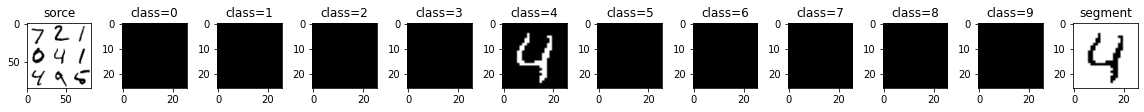

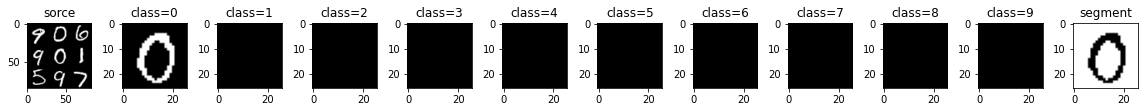

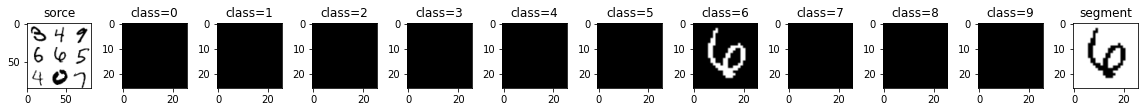

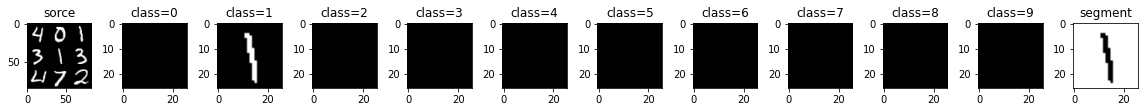

In [7]:
plt.figure(figsize=(16,8))
for source_imgs, teaching_imgs in loader_test:
    print(source_imgs[0].shape)
    print(teaching_imgs[0].shape)
    for i in range(min(mini_batch_size, 4)):
        plt_data(source_imgs[i], teaching_imgs[i])
    break

## ネットワーク構築
LUT-Netのみでは深いネットワークの学習が困難な模様なので、一旦バイナリDenseAffineで学習してから、補助層として使いながらLUT-Netを学習できる構造を検討する。
また、29段の畳み込み層で少なくとも１個の数字が畳み込み範囲に収まる広さを畳み込んだ後、数字の一部かどうか(セグメンテーション)と、どの数字か(10クラス分類)は個別に行う。

In [8]:
# バイナリ時は BIT型を使えばメモリ削減可能
bin_dtype = bb.DType.BIT if bin_mode else bb.DType.FP32

def create_lut_depthwise_conv(name, output_ch, filter_size=(3, 3), padding='valid', batch_norm=True, fw_dtype=bin_dtype):
    """LUTのDepthwiseConv層生成"""
    return bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([output_ch, 1, 1], connection='depthwise', batch_norm=batch_norm, name=(name + '_lut_dl_depthwise'), bin_dtype=fw_dtype),
                ]),
                filter_size=filter_size,
                padding=padding,
                name=name + '_lut_conv_depthwise',
                fw_dtype=fw_dtype)

def create_lut_conv1(name, output_ch, filter_size=(1, 1), padding='valid', connection='serial', batch_norm=True, fw_dtype=bin_dtype):
    """LUTのConv層生成(1段)"""
    return bb.Convolution2d(
                bb.DifferentiableLut([output_ch, 1, 1], connection=connection, batch_norm=batch_norm, name=(name + '_lut_dl'), bin_dtype=fw_dtype),
                filter_size=filter_size,
                padding=padding,
                name=(name + '_lut_conv'),
                fw_dtype=fw_dtype)

def create_lut_conv2(name, output_ch, filter_size=(1, 1), padding='valid', connection='serial', batch_norm=True, fw_dtype=bin_dtype):
    """LUTのConv層生成(2段)"""
    return bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([output_ch*6, 1, 1], connection=connection, batch_norm=batch_norm, name=(name + '_lut_dl0'), bin_dtype=fw_dtype),
                    bb.DifferentiableLut([output_ch,   1, 1], connection='serial', batch_norm=batch_norm, name=(name + '_lut_dl1'), bin_dtype=fw_dtype),
                ]),
                filter_size=filter_size,
                padding=padding,
                name=(name + '_lut_conv'),
                fw_dtype=fw_dtype)

def create_lut_conv3(name, output_ch, filter_size=(1, 1), padding='valid', connection='serial', batch_norm=True, fw_dtype=bin_dtype):
    """LUTのConv層生成(3段)"""
    return bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([output_ch*6*6, 1, 1], connection=connection, batch_norm=batch_norm, name=(name + '_lut_dl0'), bin_dtype=fw_dtype),
                    bb.DifferentiableLut([output_ch*6, 1, 1], connection='serial', batch_norm=batch_norm, name=(name + '_lut_dl1'), bin_dtype=fw_dtype),
                    bb.DifferentiableLut([output_ch,   1, 1], connection='serial', batch_norm=batch_norm, name=(name + '_lut_dl2'), bin_dtype=fw_dtype),
                ]),
                filter_size=filter_size,
                padding=padding,
                name=(name + '_lut_conv'),
                fw_dtype=fw_dtype)

def create_lut_conv_3x3(name, hidden_ch, output_ch, padding='valid', batch_norm=True, fw_dtype=bin_dtype):
    """LUTの3x3 MobileNetライクな層生成"""
    return bb.Sequential([
            create_lut_conv2(name + '_m0', hidden_ch, filter_size=(1, 1), connection='serial', fw_dtype=fw_dtype),
            create_lut_conv2(name + '_m1', hidden_ch, filter_size=(3, 3), connection='serial', padding=padding, fw_dtype=fw_dtype),
            create_lut_conv2(name + '_m2', output_ch, filter_size=(1, 1), connection='serial', fw_dtype=fw_dtype),
        ])

def create_dense_affine(name, output_ch, fw_dtype=bin_dtype):
    """バイナリ化したDenseAffine層生成"""
    return bb.Sequential([
                bb.DenseAffine([output_ch, 1, 1], name=(name + '_dense_affine')),
                bb.BatchNormalization(name=(name + '_dense_bn')),
                bb.Binarize(name=(name + '_dense_act'), bin_dtype=fw_dtype),
            ])

def create_dense_conv(name, output_ch, filter_size=(1, 1), padding='valid', fw_dtype=bin_dtype):
    """バイナリ化したDenseConv層生成"""
    return bb.Convolution2d(
                create_dense_affine(name, output_ch, fw_dtype),
                filter_size=filter_size,
                padding=padding,
                name=(name + '_dense_conv'),
                fw_dtype=fw_dtype)


class SemanticSegmentationNetwork(bb.Sequential):
    """セグメンテーション＋分類ネットワーク"""
    def __init__(self):
        self.input_r2b = bb.RealToBinary(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype)
        self.cls_b2r = bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
        self.seg_b2r = bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
        
        # Convolution層生成
        self.net_cnv = bb.Sequential()
        for i in range(29):
            layer_name = 'cnv%d'%(i)
            cnv_lut   = create_lut_conv_3x3(layer_name, 2*36, 36, padding='valid', batch_norm=True, fw_dtype=bin_dtype)
            cnv_dense = create_dense_conv(layer_name, 36, filter_size=(3, 3), padding='valid', fw_dtype=bin_dtype)
            self.net_cnv.append(
                    bb.Switcher({
                        'lut': cnv_lut,
                        'dense': cnv_dense
                    }, init_model_name='dense'))
        
        # Classification層生成
        self.net_cls = bb.Sequential([
                    bb.Switcher({
                            'lut':   create_lut_conv2('cls0', 2*36, filter_size=(1, 1)),
                            'dense': create_dense_conv('cls0', 2*36, filter_size=(1, 1)),
                        }, init_model_name='dense'),
                    bb.Switcher({
                            'lut':   create_lut_conv3('cls1', 10, filter_size=(1, 1)),
                            'dense': create_dense_conv('cls1', 10, filter_size=(1, 1)),
                        }, init_model_name='dense')
                ])
        
        # Segmentation層生成
        self.net_seg = bb.Sequential([
                    bb.Switcher({
                            'lut':   create_lut_conv2('seg0', 2*36, filter_size=(1, 1)),
                            'dense': create_dense_conv('seg0', 2*36, filter_size=(1, 1)),
                        }, init_model_name='dense'),
                    bb.Switcher({
                            'lut':   create_lut_conv3('seg1', 1, filter_size=(1, 1)),
                            'dense': create_dense_conv('seg1', 1, filter_size=(1, 1)),
                        }, init_model_name='dense')
                ])
                
        super(SemanticSegmentationNetwork, self).__init__([self.net_cnv, self.net_cls, self.net_seg])
        
    def set_input_shape(self, shape):
        shape = self.input_r2b.set_input_shape(shape)
        shape = self.net_cnv.set_input_shape(shape)
        shape_cls = self.net_cls.set_input_shape(shape)
        self.cls_b2r.set_input_shape(shape_cls)
        shape_seg = self.net_seg.set_input_shape(shape)
        self.seg_b2r.set_input_shape(shape_seg)
        
    def forward(self, x, train):
        x = self.input_r2b.forward(x, train)
        x = self.net_cnv.forward(x, train)
        y0 = self.net_cls.forward(x, train)
        y0 = self.cls_b2r.forward(y0)
        y1 = self.net_seg.forward(x, train)
        y1 = self.seg_b2r.forward(y1)
        return y0, y1
    
    def backward(self, dy0, dy1):
        dy0 = self.cls_b2r.backward(dy0)
        dy0 = self.net_cls.backward(dy0)
        dy1 = self.seg_b2r.backward(dy1)
        dy1 = self.net_seg.backward(dy1)
        dx = self.net_cnv.backward(dy0*0.5 + dy1*0.5)
        return dx

In [9]:
# ネットワーク生成
net = SemanticSegmentationNetwork()
net.send_command("switch_model dense")
net.set_input_shape([1, rows*28, cols*28])
net.set_name(net_name)
net.send_command("binary true")

## 学習実施

学習を行います。
前段(Convolution層)と後段(Classification層/Segmentation層)をそれぞれ蒸留学習する

In [10]:
def learning(data_path, net, epochs=2):
    """ネット全体の学習"""
    # learning
    loss0     = bb.LossSoftmaxCrossEntropy()
    loss1     = bb.LossSigmoidCrossEntropy()
    metrics0  = bb.MetricsCategoricalAccuracy()
    metrics1  = bb.MetricsBinaryCategoricalAccuracy()
    optimizer = bb.OptimizerAdam()

    optimizer.set_variables(net.get_parameters(), net.get_gradients())

    for epoch in range(epochs):
        # learning
        loss0.clear()
        metrics0.clear()
        loss1.clear()
        metrics1.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                t0_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs[:,0:10,:,:]).astype(np.float32))
                t1_buf = bb.FrameBuffer.from_numpy(1.0 - np.array(t_imgs[:,10:11,:,:]).astype(np.float32))
                y0_buf, y1_buf = net.forward(x_buf, train=True)

                dy0_buf = loss0.calculate(y0_buf, t0_buf)
                dy1_buf = loss1.calculate(y1_buf, t1_buf)
                metrics0.calculate(y0_buf, t0_buf)
                metrics1.calculate(y1_buf, t1_buf)

                net.backward(dy0_buf, dy1_buf)

                optimizer.update()

                tqdm_loadr.set_postfix(loss0=loss0.get(), acc0=metrics0.get(), loss1=loss1.get(), acc1=metrics1.get())

        # test
        loss0.clear()
        metrics0.clear()
        loss1.clear()
        metrics1.clear()
        for x_imgs, t_imgs in loader_test:
            x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
            t0_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs[:,0:10,:,:]).astype(np.float32))
            t1_buf = bb.FrameBuffer.from_numpy(1.0 - np.array(t_imgs[:,10:11,:,:]).astype(np.float32))

            y0_buf, y1_buf = net.forward(x_buf, train=False)

            loss0.calculate(y0_buf, t0_buf)
            loss1.calculate(y1_buf, t1_buf)
            metrics0.calculate(y0_buf, t0_buf)
            metrics1.calculate(y1_buf, t1_buf)

        bb.save_networks(data_path, net)
        
        print('epoch[%d] : loss0=%f acc0=%f loss1=%f acc1=%f' % (epoch, loss0.get(), metrics0.get(), loss1.get(), metrics1.get()))
        view(net, loader_test)

In [11]:
def learning_cnv(data_path, net, index, epochs=2):
    """前段畳み込み層の学習(index以降のみを学習)"""
    # learning
    loss0     = bb.LossSoftmaxCrossEntropy()
    loss1     = bb.LossSigmoidCrossEntropy()
    metrics0  = bb.MetricsCategoricalAccuracy()
    metrics1  = bb.MetricsBinaryCategoricalAccuracy()
    optimizer = bb.OptimizerAdam()

    optimizer.set_variables(net.get_parameters(), net.get_gradients())

    for epoch in range(epochs):
        # learning
        loss0.clear()
        metrics0.clear()
        loss1.clear()
        metrics1.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                t0_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs[:,0:10,:,:]).astype(np.float32))
                t1_buf = bb.FrameBuffer.from_numpy(1.0 - np.array(t_imgs[:,10:11,:,:]).astype(np.float32))
                
                x_buf = net.input_r2b.forward(x_buf, train=False)
                for i in range(29):
                    x_buf = net.net_cnv[i].forward(x_buf, train=(i >= index))
                
                y0_buf = net.net_cls.forward(x_buf, train=True)
                y0_buf = net.cls_b2r.forward(y0_buf, train=True)
                y1_buf = net.net_seg.forward(x_buf, train=True)
                y1_buf = net.seg_b2r.forward(y1_buf, train=True)
                
                dy0_buf = loss0.calculate(y0_buf, t0_buf)
                dy1_buf = loss1.calculate(y1_buf, t1_buf)
                metrics0.calculate(y0_buf, t0_buf)
                metrics1.calculate(y1_buf, t1_buf)
                
                dy0_buf = net.cls_b2r.backward(dy0_buf)
                dy0_buf = net.net_cls.backward(dy0_buf)                
                dy1_buf = net.seg_b2r.backward(dy1_buf)
                dy1_buf = net.net_seg.backward(dy1_buf)
                
                dy_buf = dy0_buf*0.5 + dy1_buf*0.5
                for i in reversed(range(index, 29)):
                    dy_buf = net.net_cnv[i].backward(dy_buf)
                
                optimizer.update()

                tqdm_loadr.set_postfix(loss0=loss0.get(), acc0=metrics0.get(), loss1=loss1.get(), acc1=metrics1.get())

        # test
        loss0.clear()
        metrics0.clear()
        loss1.clear()
        metrics1.clear()
        for x_imgs, t_imgs in loader_test:
            x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
            t0_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs[:,0:10,:,:]).astype(np.float32))
            t1_buf = bb.FrameBuffer.from_numpy(1.0 - np.array(t_imgs[:,10:11,:,:]).astype(np.float32))

            y0_buf, y1_buf = net.forward(x_buf, train=False)

            loss0.calculate(y0_buf, t0_buf)
            loss1.calculate(y1_buf, t1_buf)
            metrics0.calculate(y0_buf, t0_buf)
            metrics1.calculate(y1_buf, t1_buf)

        bb.save_networks(data_path, net)
        
        print('epoch[%d] : loss0=%f acc0=%f loss1=%f acc1=%f' % (epoch, loss0.get(), metrics0.get(), loss1.get(), metrics1.get()))
        view(net, loader_test)

In [12]:
def learning_post(data_path, net, epochs=2):
    """後段処理のみの学習"""
    # learning
    loss0      = bb.LossSoftmaxCrossEntropy()
    loss1      = bb.LossSigmoidCrossEntropy()
    metrics0   = bb.MetricsCategoricalAccuracy()
    metrics1   = bb.MetricsBinaryCategoricalAccuracy()
    optimizer0 = bb.OptimizerAdam()
    optimizer1 = bb.OptimizerAdam()
    
    optimizer0.set_variables(net.net_cls.get_parameters(), net.net_cls.get_gradients())
    optimizer1.set_variables(net.net_seg.get_parameters(), net.net_seg.get_gradients())
    
    for epoch in range(epochs):
        # learning
        loss0.clear()
        metrics0.clear()
        loss1.clear()
        metrics1.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                t0_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs[:,0:10,:,:]).astype(np.float32))
                t1_buf = bb.FrameBuffer.from_numpy(1.0 - np.array(t_imgs[:,10:11,:,:]).astype(np.float32))
                
                x_buf = net.input_r2b.forward(x_buf, train=False)
                x_buf = net.net_cnv.forward(x_buf, train=False)
                
                y0_buf = net.net_cls.forward(x_buf, train=True)
                y0_buf = net.cls_b2r.forward(y0_buf, train=True)
                
                y1_buf = net.net_seg.forward(x_buf, train=True)
                y1_buf = net.seg_b2r.forward(y1_buf, train=True)
                
                dy0_buf = loss0.calculate(y0_buf, t0_buf)
                dy1_buf = loss1.calculate(y1_buf, t1_buf)
                metrics0.calculate(y0_buf, t0_buf)
                metrics1.calculate(y1_buf, t1_buf)
                
                dy0_buf = net.cls_b2r.backward(dy0_buf)
                dy0_buf = net.net_cls.backward(dy0_buf)
                
                dy1_buf = net.seg_b2r.backward(dy1_buf)
                dy1_buf = net.net_seg.backward(dy1_buf)
                
                optimizer0.update()
                optimizer1.update()
                
                tqdm_loadr.set_postfix(loss0=loss0.get(), acc0=metrics0.get(), loss1=loss1.get(), acc1=metrics1.get())

        # test
        loss0.clear()
        metrics0.clear()
        loss1.clear()
        metrics1.clear()
        for x_imgs, t_imgs in loader_test:
            x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
            t0_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs[:,0:10,:,:]).astype(np.float32))
            t1_buf = bb.FrameBuffer.from_numpy(1.0 - np.array(t_imgs[:,10:11,:,:]).astype(np.float32))

            y0_buf, y1_buf = net.forward(x_buf, train=False)

            loss0.calculate(y0_buf, t0_buf)
            loss1.calculate(y1_buf, t1_buf)
            metrics0.calculate(y0_buf, t0_buf)
            metrics1.calculate(y1_buf, t1_buf)

        bb.save_networks(data_path, net)
        
        print('epoch[%d] : loss0=%f acc0=%f loss1=%f acc1=%f' % (epoch, loss0.get(), metrics0.get(), loss1.get(), metrics1.get()))
        view(net, loader_test)

In [13]:
def distillation_cnv(data_path, net, index, epochs=4):
    """前段畳み込み層の蒸留"""
    # learning
    loss      = bb.LossMeanSquaredError()
    optimizer = bb.OptimizerAdam()
    
    cnv_layer = net.net_cnv[index]
    
    bin2real0 = bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
    bin2real1 = bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
    
    # LUT層をOptimizerに接続
    cnv_layer.send_command("switch_model lut")
    cnv_layer.send_command('parameter_lock false')
    optimizer.set_variables(cnv_layer.get_parameters(), cnv_layer.get_gradients())
    
    for epoch in range(epochs):
        # learning
        loss.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                # LUTに切り替えて前段計算
                net.send_command("switch_model lut")                
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                x_buf = net.input_r2b.forward(x_buf, train=False)
                for i in range(index):
                    x_buf = net.net_cnv[i].forward(x_buf, train=False)
                
                # dense に切り替えて教師データ生成
                cnv_layer.send_command("switch_model dense")
                t_buf = cnv_layer.forward(x_buf, train=False)
                t_buf = bin2real0.forward(t_buf, train=False)
                
                # LUTに戻して学習
                cnv_layer.send_command("switch_model lut")
                y_buf = cnv_layer.forward(x_buf, train=True)
                y_buf = bin2real1.forward(y_buf, train=True)
                
                dy_buf = loss.calculate(y_buf, t_buf)
                
                dy_buf = bin2real1.backward(dy_buf)
                cnv_layer.backward(dy_buf)
                optimizer.update()
                
                tqdm_loadr.set_postfix(loss=loss.get())
        
        bb.save_networks(data_path, net)
        print('distillation epoch[%d] : loss=%f' % (epoch, loss.get()))

In [14]:
def distillation_post(data_path, net, epochs=4):
    """後段処理の蒸留"""
    # learning
    loss0      = bb.LossMeanSquaredError()
    loss1      = bb.LossMeanSquaredError()
    optimizer0 = bb.OptimizerAdam()
    optimizer1 = bb.OptimizerAdam()
        
    net.send_command("switch_model lut")
    
    optimizer0.set_variables(net.net_cls.get_parameters(), net.net_cls.get_gradients())
    optimizer1.set_variables(net.net_seg.get_parameters(), net.net_seg.get_gradients())
    
    for epoch in range(epochs):
        # learning
        loss0.clear()
        loss1.clear()
        with tqdm(loader_train) as tqdm_loadr:
            for x_imgs, t_imgs in tqdm_loadr:
                # LUTに切り替えて前段計算
                net.send_command("switch_model lut")                
                x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
                x_buf = net.input_r2b.forward(x_buf, train=False)
                x_buf = net.net_cnv.forward(x_buf, train=False)
                
                # dense に切り替えて教師データ生成
                net.net_cls.send_command("switch_model dense")
                t0_buf = net.net_cls.forward(x_buf, train=False)
                t0_buf = net.cls_b2r.forward(t0_buf, train=False)
                
                net.net_seg.send_command("switch_model dense")
                t1_buf = net.net_seg.forward(x_buf, train=False)
                t1_buf = net.seg_b2r.forward(t1_buf, train=False)
                
                # LUTに戻して学習
                net.net_cls.send_command("switch_model lut")
                y0_buf = net.net_cls.forward(x_buf, train=True)
                y0_buf = net.cls_b2r.forward(y0_buf, train=True)
                
                net.net_seg.send_command("switch_model lut")
                y1_buf = net.net_seg.forward(x_buf, train=True)
                y1_buf = net.seg_b2r.forward(y1_buf, train=True)
                
                dy0_buf = loss0.calculate(y0_buf, t0_buf)
                dy1_buf = loss1.calculate(y1_buf, t1_buf)
                
                dy0_buf = net.cls_b2r.backward(dy0_buf)
                net.net_cls.backward(dy0_buf)
                
                dy1_buf = net.seg_b2r.backward(dy1_buf)
                net.net_seg.backward(dy1_buf)
                
                optimizer0.update()
                optimizer1.update()
                
                tqdm_loadr.set_postfix(loss0=loss0.get(), loss1=loss1.get())
        
        bb.save_networks(data_path, net)
        print('distillation epoch[%d] : loss0=%f loss1=%f' % (epoch, loss0.get(), loss1.get()))

In [15]:
# 基準となるDenseAffineで学習(乱数初期値次第でなかなか学習が進行しないケースがあるので環境に応じてリトライが必要な場合があります)
if not bb.load_networks(data_path, net, name='dense'):
    bb.load_networks(os.path.join(data_path, 'dense'), net)
    net.send_command("switch_model dense")
    net.send_command('parameter_lock false')
    learning(os.path.join(data_path, 'dense'), net, epochs=64)
    bb.save_networks(data_path, net, name='dense')
    bb.save_networks(data_path, net, name='dense_layers', write_layers=True)  # 層別出力もしておく

In [16]:
# 畳み込み層のLUT学習
if not bb.load_networks(data_path, net, name='cnv28'):
    for i in range(29):
        layer_name = 'cnv%d'%i
        print('----- %s -----'%layer_name)
        if not bb.load_networks(data_path, net, name=layer_name):
            # 蒸留
            distillation_cnv(os.path.join(data_path, layer_name), net, i, epochs=4)

            # 全体初期化
            net.send_command("switch_model dense")
            net.send_command('parameter_lock true')

            # LUT切り替え
            for j in range(i+1):
                net.net_cnv[j].send_command("switch_model lut")
            view(net, loader_test)

            # 個別学習
            net.net_cnv[i].send_command('parameter_lock false')
        #   learning(os.path.join(data_path, layer_name), net, epochs=2)  # 蒸留で代替

            # 後段含めた学習
            net.send_command('parameter_lock false')
            for j in range(i):
                net.net_cnv[j].send_command("parameter_lock true")
            learning_cnv(os.path.join(data_path, layer_name), net, i, epochs=2)
        #   learning(os.path.join(data_path, layer_name), net, epochs=2)

            # 保存
            bb.save_networks(data_path, net, name=layer_name)

In [17]:
# 後段の学習
if not bb.load_networks(data_path, net, name='post'):
    # 後段を蒸留
    net.send_command('parameter_lock false')
    distillation_post(os.path.join(data_path, 'post_distillation'), net, epochs=8)
    
    # LUTに切り替えて最終学習
    net.send_command("switch_model lut")
    net.send_command('parameter_lock false')
    net.net_cnv.send_command('parameter_lock true')
    learning_post(os.path.join(data_path, 'post'), net, epochs=4)
    bb.save_networks(data_path, net, name='post')

In [18]:
# 最終版を記録
bb.save_networks(data_path, net, name='final')
bb.save_networks(data_path, net, name='final_layers', write_layers=True)  # 層別出力もしておく

'final_layers'

<Figure size 1152x576 with 0 Axes>

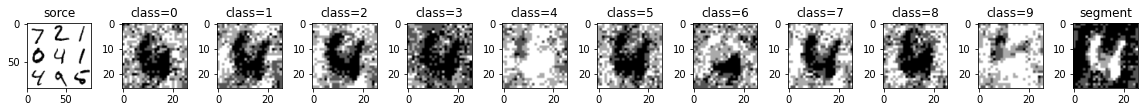

<Figure size 1152x576 with 0 Axes>

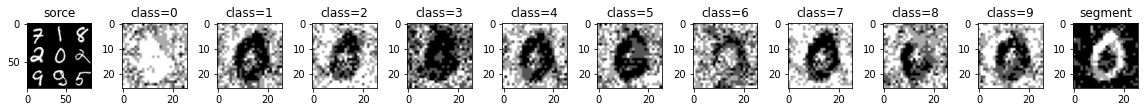

<Figure size 1152x576 with 0 Axes>

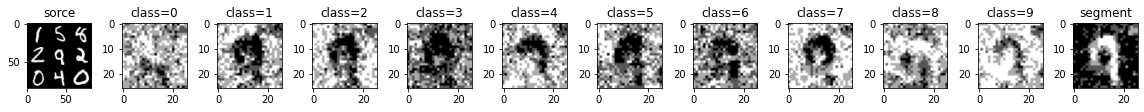

<Figure size 1152x576 with 0 Axes>

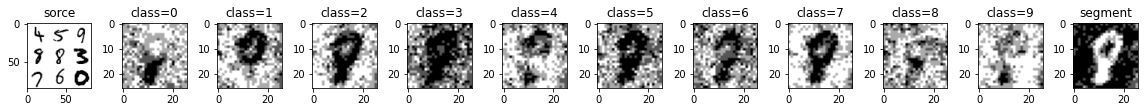

In [19]:
# 学習結果の表示
view(net, loader_test, 4)

## RTL出力

Verilog 変換を行います

In [20]:
# export verilog
with open(output_velilog_file, 'w') as f:
    f.write('`timescale 1ns / 1ps\n\n')
    bb.dump_verilog_lut_cnv_layers(f, 'MnistConv', net.net_cnv)
    bb.dump_verilog_lut_cnv_layers(f, 'MnistClassification', net.net_cls)
    bb.dump_verilog_lut_cnv_layers(f, 'MnistSegmentation', net.net_seg)

# Simulation用ファイルに上書きコピー
shutil.copyfile(output_velilog_file, sim_velilog_file)

'../../verilog/mnist\\MnistSemanticSegmentation.v'